<a href="https://colab.research.google.com/github/nandini-sundar/cs230-waste-classification-and-detection/blob/master/Waste_Object_Detection_Using_Tensorflow_(Collage).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Waste Object Detection using Tensorflow Object Detection API (Collage images)**

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
repo_url = 'https://github.com/nandini-sundar/CS230-Fall2019-TrashNet-Collage'

# Configurations and Hyperparameters

In [0]:
# Number of training steps.
num_steps = 5000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 16
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 16
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

## Clone dataset and install required packages

In [0]:
import os

%cd /content

repo_dir_path = "/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/"

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

In [10]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
Selecting previously unselected package python-bs4.
(Reading database ... 135718 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpa

In [11]:
!git clone https://github.com/nandini-sundar/cs230-waste-classification-and-detection

Cloning into 'cs230-waste-classification-and-detection'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 110 (delta 49), reused 81 (delta 32), pack-reused 0
Receiving objects: 100% (110/110), 13.23 MiB | 24.02 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [18]:
!git clone https://github.com/nandini-sundar/CS230-Fall2019-TrashNet-Collage.git

Cloning into 'CS230-Fall2019-TrashNet-Collage'...
remote: Enumerating objects: 4523, done.
remote: Total 4523 (delta 0), reused 0 (delta 0), pack-reused 4523
Receiving objects: 100% (4523/4523), 725.94 MiB | 27.50 MiB/s, done.
Resolving deltas: 100% (1503/1503), done.
Checking out files: 100% (9010/9010), done.


In [21]:
!ls /content/drive/My\ Drive/CS230-Fall2019-TrashNet-Collage/annotations

label_map.pbtxt  train_labels.csv  voc_xmls
test_labels.csv  val_labels.csv    yolo_labels


# Ensure that the bounding boxes are within the bounds of the image

In [41]:
import csv
import cv2 
import os
import numpy as np
import pandas as pd

FOLDER = '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/val_set/'
CSV_FILE = '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/annotations/val_labels.csv'

csv = pd.read_csv(CSV_FILE)
first = True
    
cnt = 0
error_cnt = 0
error = False
for ind in csv.index:
    if error == True:
        error_cnt += 1
        error = False
        
    if first == True:
        first = False
        continue
    
    cnt += 1
    
    name, width, height, xmin, ymin, xmax, ymax = csv['filename'][ind], int(csv['width'][ind]), int(csv['height'][ind]), int(csv['xmin'][ind]), int(csv['ymin'][ind]), int(csv['xmax'][ind]), int(csv['ymax'][ind])
    
    path = os.path.join(FOLDER, name)
    img = cv2.imread(path)
    
    
    if type(img) == type(None):
        error = True
        print('Could not read image', path)
        continue
    
    org_height, org_width = img.shape[:2]
    
    if org_width != width:
        error = True
        print('Width mismatch for image: ', name, width, '!=', org_width)
    
    if org_height != height:
        error = True
        print('Height mismatch for image: ', name, height, '!=', org_height)
    
    if xmin > org_width:
        error = True
        print('XMIN > org_width for file', name)
        
    if xmax > org_width:
        error = True
        csv['xmax'][ind] = str(org_width)
        print('XMAX > org_width for file', name)
    
    if ymin > org_height:
        error = True
        print('YMIN > org_height for file', name)
    
    if ymax > org_height:
        error = True
        csv['ymax'][ind] = str(org_height)
        print('YMAX > org_height for file', name)
    
    if error == True:
        print('Error for file: %s' % name)
        print()
    
print('Checked %d files and realized %d errors' % (cnt, error_cnt))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


YMAX > org_height for file 318.png
Error for file: 318.png

XMAX > org_width for file 1397.png
Error for file: 1397.png

YMAX > org_height for file 1397.png
Error for file: 1397.png

XMAX > org_width for file 1352.png
YMAX > org_height for file 1352.png
Error for file: 1352.png

YMAX > org_height for file 625.png
Error for file: 625.png

XMAX > org_width for file 685.png
Error for file: 685.png

YMAX > org_height for file 685.png
Error for file: 685.png

YMAX > org_height for file 652.png
Error for file: 652.png

YMAX > org_height for file 1137.png
Error for file: 1137.png

XMAX > org_width for file 859.png
Error for file: 859.png

XMAX > org_width for file 1206.png
YMAX > org_height for file 1206.png
Error for file: 1206.png

YMAX > org_height for file 1115.png
Error for file: 1115.png

YMAX > org_height for file 1115.png
Error for file: 1115.png

XMAX > org_width for file 1231.png
Error for file: 1231.png

XMAX > org_width for file 397.png
Error for file: 397.png

XMAX > org_width fo

In [0]:
csv.to_csv(CSV_FILE)

# Create TFRecords

In [43]:
%cd /content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/
!pwd

# Generate `train.record`
!python /content/cs230-waste-classification-and-detection/data_processing/generate_tfrecord.py --csv_input=annotations/train_labels.csv --output_path=annotations/train.record --img_path=Split/train_set --label_map annotations/label_map.pbtxt

# Generate `val.record`
!python /content/cs230-waste-classification-and-detection/data_processing/generate_tfrecord.py --csv_input=annotations/val_labels.csv --output_path=annotations/val.record --img_path=Split/val_set --label_map annotations/label_map.pbtxt

# Generate `val.record`
!python /content/cs230-waste-classification-and-detection/data_processing/generate_tfrecord.py --csv_input=annotations/test_labels.csv --output_path=annotations/test.record --img_path=Split/test_set --label_map annotations/label_map.pbtxt

/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage
/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage


W1208 20:17:41.552222 140105709156224 module_wrapper.py:139] From /content/cs230-waste-classification-and-detection/data_processing/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1208 20:17:41.685165 140105709156224 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/annotations/train.record


W1208 20:17:52.000521 139822594185088 module_wrapper.py:139] From /content/cs230-waste-classification-and-detection/data_processing/generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W1208 20:17:52.021668 139822594185088 module_w

In [44]:
!ls -ltra "/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/annotations"


total 752778
-rw------- 1 root root       232 Dec  8 19:51 label_map.pbtxt
drwx------ 2 root root      4096 Dec  8 19:51 voc_xmls
drwx------ 2 root root      4096 Dec  8 19:51 yolo_labels
-rw------- 1 root root    213188 Dec  8 19:57 train_labels.csv
-rw------- 1 root root     26134 Dec  8 19:58 test_labels.csv
-rw------- 1 root root     26131 Dec  8 20:17 val_labels.csv
-rw------- 1 root root 615695775 Dec  8 20:17 train.record
-rw------- 1 root root  77730243 Dec  8 20:17 val.record
-rw------- 1 root root  77142462 Dec  8 20:17 test.record


In [0]:
val_record_fname = '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/annotations/val.record'
train_record_fname = '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/annotations/train.record'
label_map_pbtxt_fname = '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/annotations/label_map.pbtxt'

# Download Base Model

In [46]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [47]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 111M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 71 root   root 4.0K Dec  8 20:18 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  55M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  51M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  16K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 5.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 3.2K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [48]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

# Configure Training Pipeline

In [0]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)
assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [0]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [35]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
    print(s)
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(val_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    print(s)
    f.write(s)


# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 37
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        t

In [51]:
!cat {pipeline_fname}

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 6
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        tru

In [0]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

# Reset GPU to avoid GPU overflow issues

In [53]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.5 GB  | Proc size: 379.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# Train the model

In [54]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1208 20:19:11.484352 139781316679552 module_wrapper.py:139] From /content/models/research/object_detection/utils/config_util.py:102: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1208 20:19:11.486798 139781316679552 module_wrapper.py:139] From /content/models/research/object_detection/model_lib.py:628: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1208 20:19:11.486932 139781316679552 model_lib.py:629] Forced number of epochs for all eval validations to be 1.

W1208 20:19:11.487025 139781316679552 module_wrapper.py:139] From /content/models/res

In [55]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1575836389.ad6e7449fc6e
export
graph.pbtxt
model.ckpt-3810.data-00000-of-00001
model.ckpt-3810.index
model.ckpt-3810.meta
model.ckpt-4192.data-00000-of-00001
model.ckpt-4192.index
model.ckpt-4192.meta
model.ckpt-4573.data-00000-of-00001
model.ckpt-4573.index
model.ckpt-4573.meta
model.ckpt-4953.data-00000-of-00001
model.ckpt-4953.index
model.ckpt-4953.meta
model.ckpt-5000.data-00000-of-00001
model.ckpt-5000.index
model.ckpt-5000.meta


# Export a Trained Inference Graph

In [56]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-5000
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1208 22:41:40.642030 140187086759808 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1208 22:41:40.647129 140187086759808 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:402: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1208 22:41:40.647436 140187086759808 module_wrapper.py:139] From /content/models/research/object_detection/exporter.py:121: The name tf.placeholder is deprecated. Please use tf.c

In [57]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [0]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [59]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 51M Dec  8 22:41 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


# Run Inference Test 

Test with the images in the test_set directory

In [68]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "Split/test_set")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.png"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/10.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/100.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1028.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1029.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1030.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1040.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1041.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1048.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1068.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/107.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1083.png', '/content/drive/My Drive/CS230-Fall2019-TrashNet-Collage/Split/test_set/1099.png', '/conte

/content/models/research/object_detection


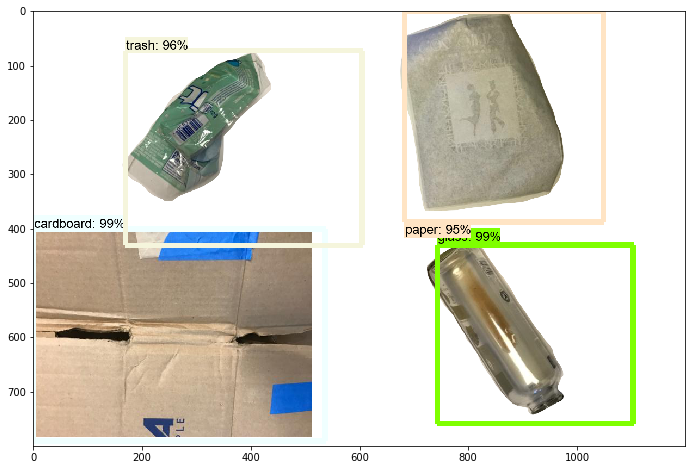

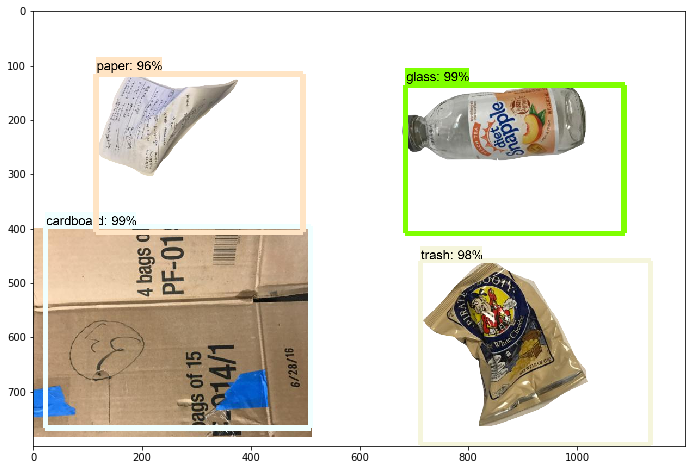

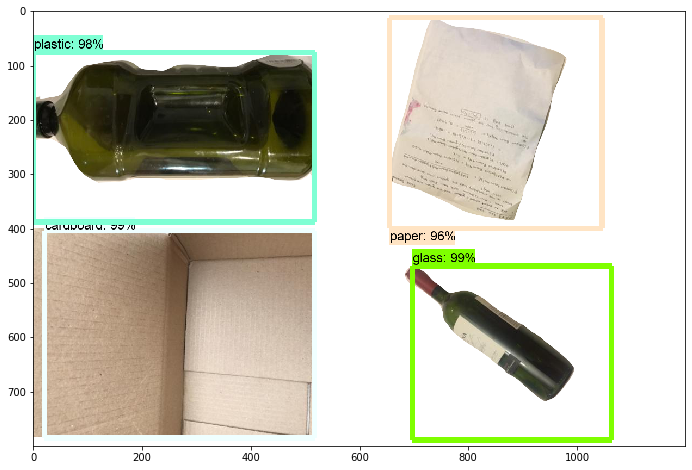

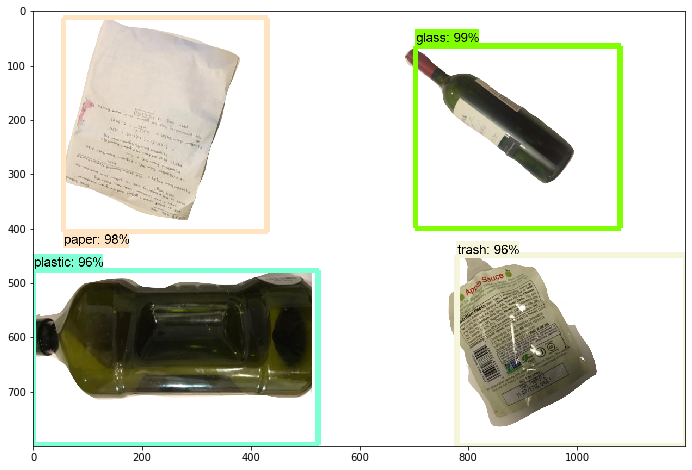

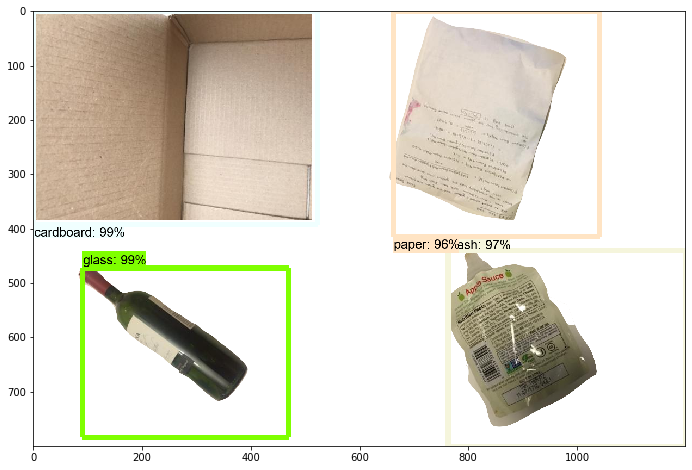

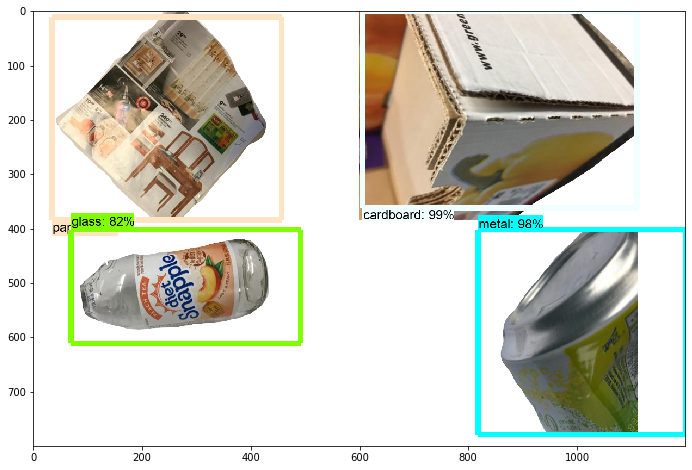

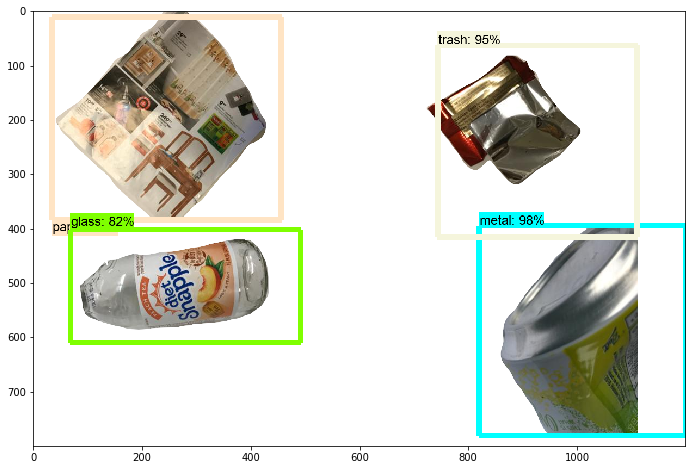

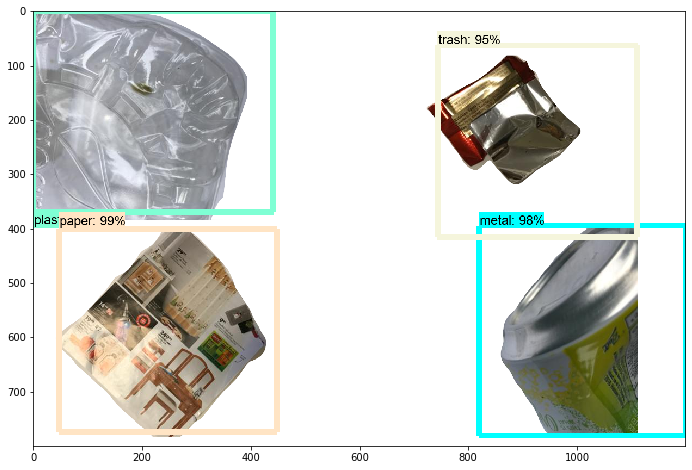

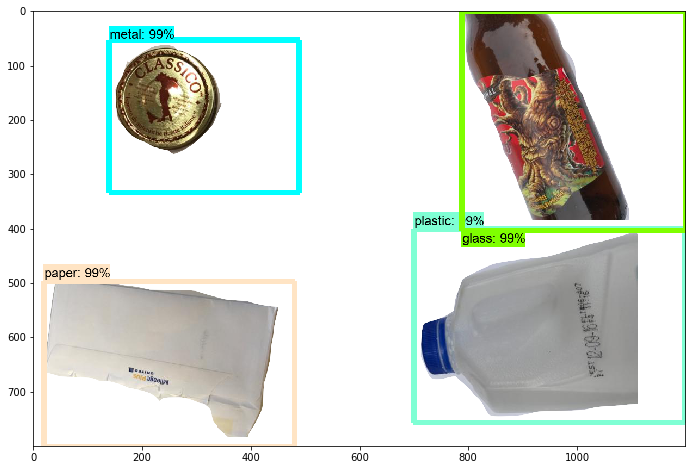

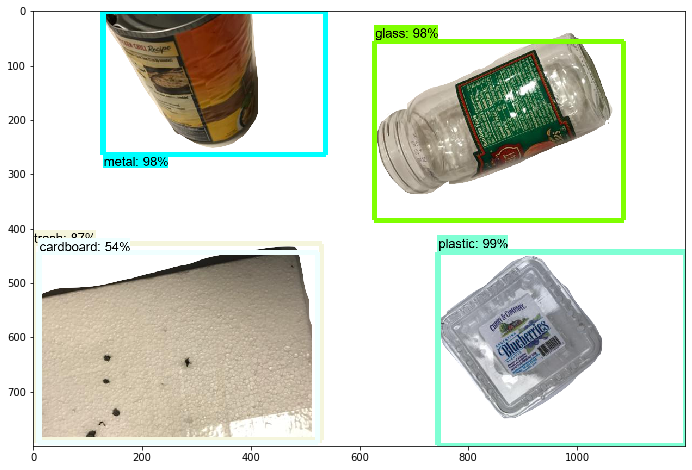

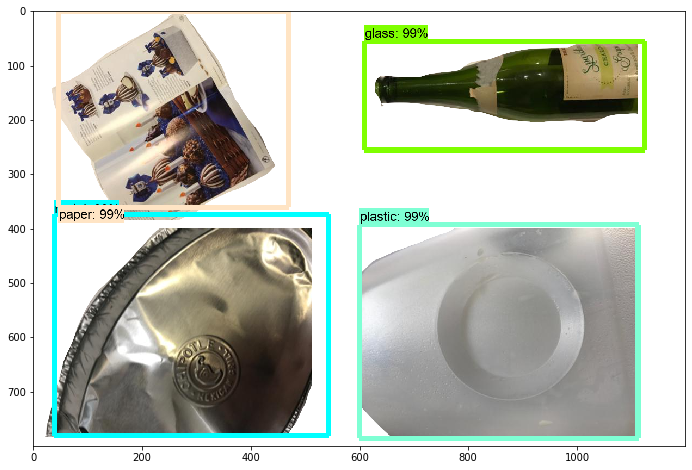

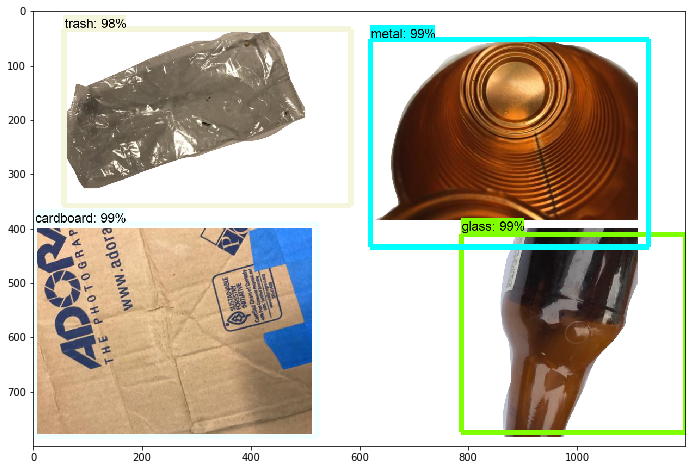

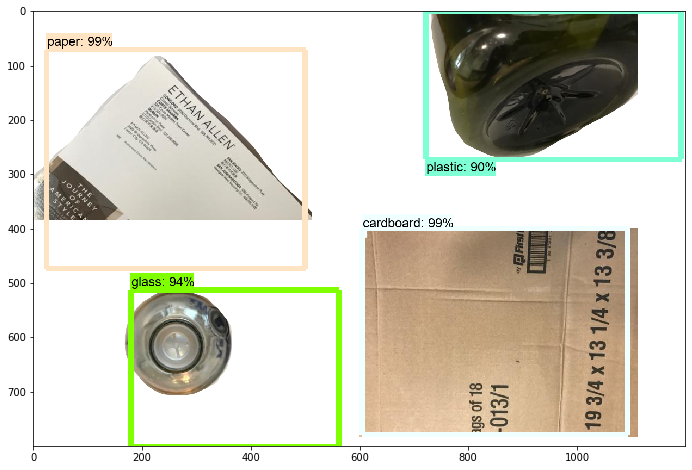

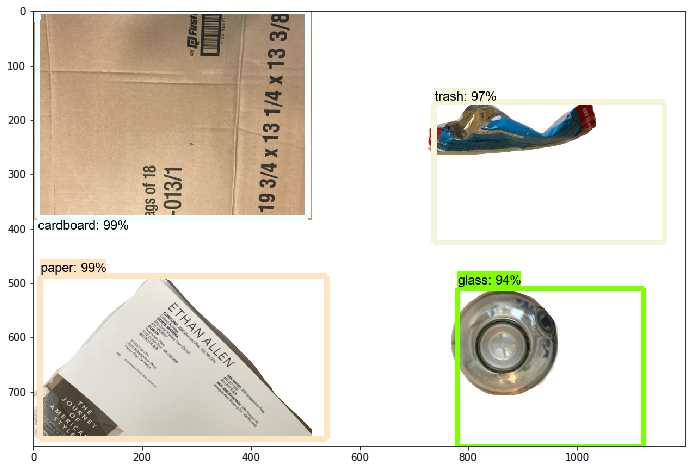

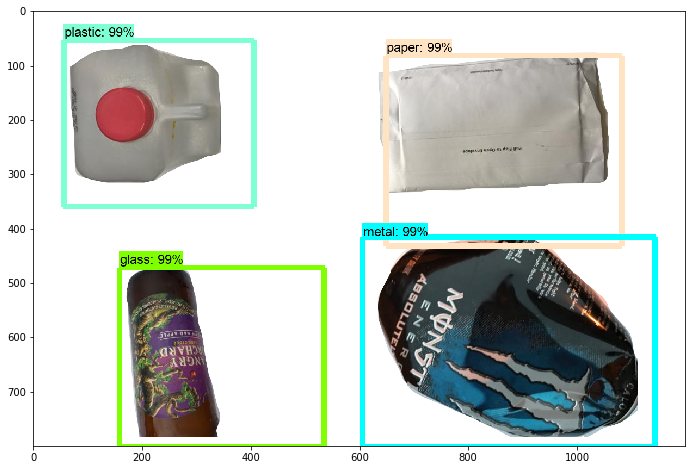

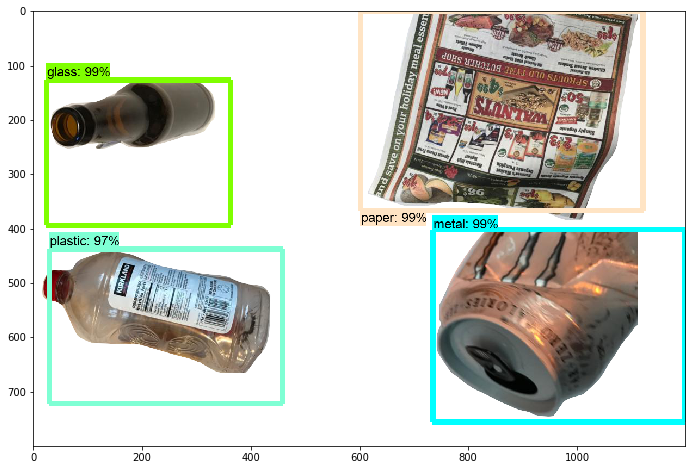

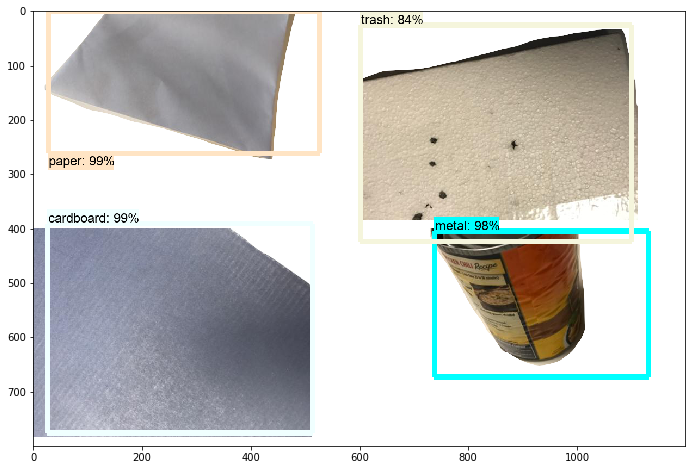

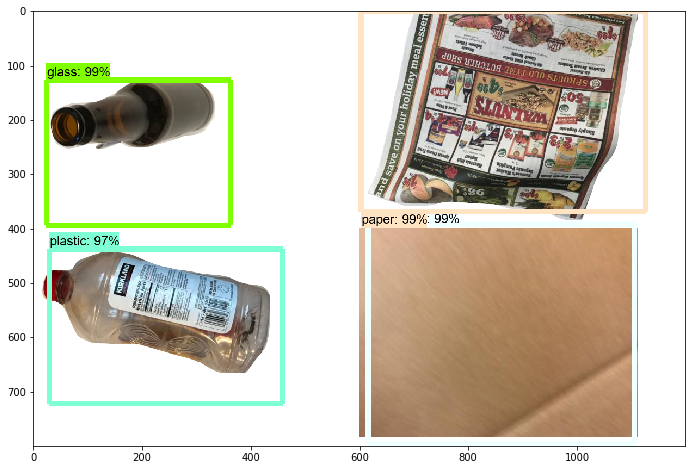

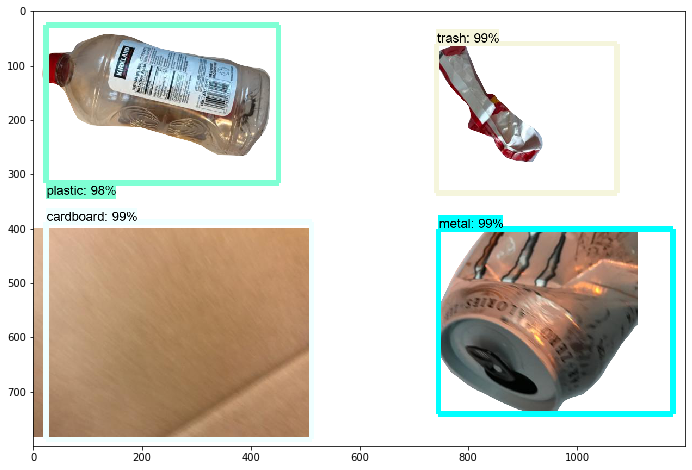

In [118]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import imageio

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict


for image_path in TEST_IMAGE_PATHS[0:19]:
    image_4 = imageio.imread(image_path)
    #plt.imshow(image_4)
    #print(image_4.shape)
    from PIL import Image

    png = Image.open(image_path)
    png.load() # required for png.split()

    background = Image.new("RGB", png.size, (255, 255, 255))
    background.paste(png, mask=png.split()[3]) # 3 is the alpha channel

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(background)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=10)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
